# Push Bayesian Deep Learning Tutorial

## Introduction

In this notebook, we introduce Bayesian Deep Learning (BDL) and demonstrate how to use Push to perform BDL by running a deep ensemble. Bayesian Deep Learning methods seek to describe a model through distributions instead of point estimates. We want to know the distribution of possible parameter settings or predictions for a given dataset, so that we can derive new metrics like uncertainty. For example, by training 16 different models on the same dataset we obtain 16 unique parameter settings. If we make a prediction on with each model, we obtain a distribution of 16 different predictions. If we define uncertainty to be the variance in prediction results, we can quantify uncertainty based on the how much our predictions vary for a given input. This is a fundamental goal of Bayesian Deep Learning methods, as in the real world we often encounter data that is very different from our training data. In instances where our models is seeing new data that is very dissimilar from its training set, we would like to be informed that the model is less certain about its prediction. Consequently for data that is very similar to the training set, we would expect to see uncertainty be low.

## Background: The Posterior Predictive Distribution

The goal of BDL methods is to compute the *posterior predictive distribution*
$$
p(y|x, \mathcal{D}) = \int p(y|x, \theta) p(\theta | \mathcal{D}) \, d\theta
$$
where $y$ is an output, $x$ is an input, $\theta$ are parameters, and $\mathcal{D} = (x_i, y_i)_{i}$ is a dataset. In general, this integral is intractable and must be approximated.

### Monte Carlo Approximation

We can approximate the posterior predictive distribution with a Monte Carlo approximation [1]: 
$$
p(y|x, \mathcal{D}) \approx \frac{1}{J} \sum_{j=1}^{J} p(y|x, \theta_j), \quad \theta_j \sim p(\theta | D)
$$
where each $\theta_j$ corresponds to a unique parameter setting.

### Deep Ensembles

 *Deep ensembles* train $J$ different initializations of the same neural network (NN). If we average $p(y | x, \theta_j)$ over $J$ parameter settings $\theta_j$, we are essentially performing a Monte Carlo estimate that approximates the posterior predictive distribution. Thus, deep ensembles form a simple BDL method.

## Deep Ensembles in Push

We will now introduce deep ensembles in Push. Push interoperates with PyTorch, and so all datasets and models can use PyTorch components. Push also has concurrent execution semantics.

### Dataset

For illustrative purposes, we create a random dataset with $N$ points of dimension $D$.

In [1]:
from bdl import SineDataset
import math

D = 1
batch_size = 12
N = 64
train_begin_radians = -2 * math.pi
train_end_radians = 2 * math.pi
test_begin_radians = -4 * math.pi
test_end_radians = 4 * math.pi
dataset = SineDataset(batch_size, N, D, train_begin_radians, train_end_radians)
oos_dataset = SineDataset(batch_size, N, D, test_begin_radians, test_end_radians)

```py
class SineDataset(Dataset):
    def __init__(self, batch_size, N, D, begin, end):
        self.xs = torch.linspace(begin * math.pi, end * math.pi, batch_size * N * D).reshape(batch_size * N, D)
        self.ys = torch.sin(self.xs[:, 0]).reshape(-1, 1)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

```

## Plotting the Dataset 

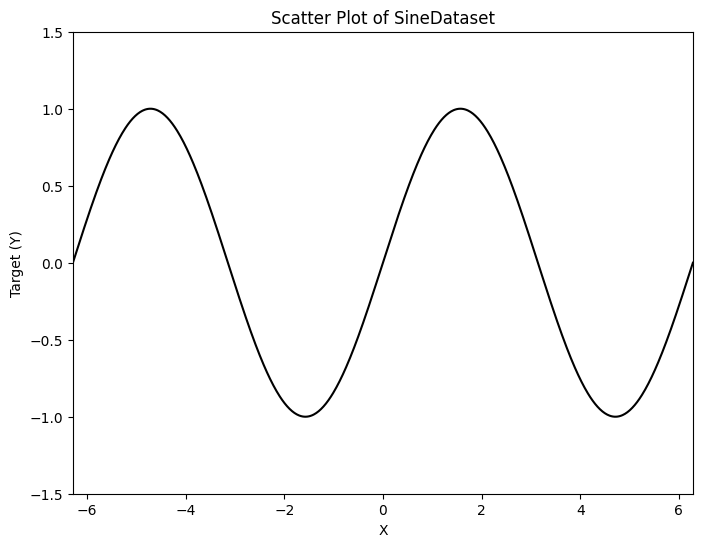

In [2]:
import matplotlib.pyplot as plt
# Extract the data
xs = dataset.xs
ys = dataset.ys
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c ="black")
plt.title('Scatter Plot of SineDataset')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

# Plotting Test (Out of Sample) Dataset

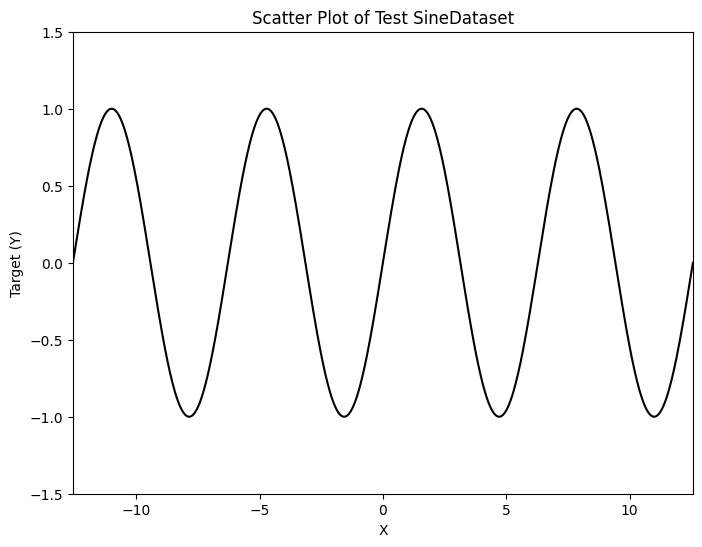

In [3]:
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c ="black")
plt.title('Scatter Plot of Test SineDataset')
plt.xlim(test_begin_radians, test_end_radians)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.show()

### Neural Network

We create a simple neural network (NN). This NN contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. 

In [4]:
from bdl import MiniNN
from bdl import BiggerNN

```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)

class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x
    
```

### Training a Standard Neural Network (num_ensemble = 1)


In [5]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

epochs = 100
num_ensembles = 1
n = 2
input_dim = 1
output_dim = 1
hidden_dim = 16
standard_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)
standard_params = standard_params[0]


 83%|████████▎ | 83/100 [00:26<00:05,  3.26it/s]

KeyboardInterrupt: 

 86%|████████▌ | 86/100 [00:27<00:04,  3.32it/s]

In the previous cell, we saved the output of our train_deep_ensemble function inside standard_params. train_deep_ensemble returns a list of all the parameters for each deep ensemble trained. Since we are only training one model, the list will contain only one parameter setting.

# Plotting one model's predictions

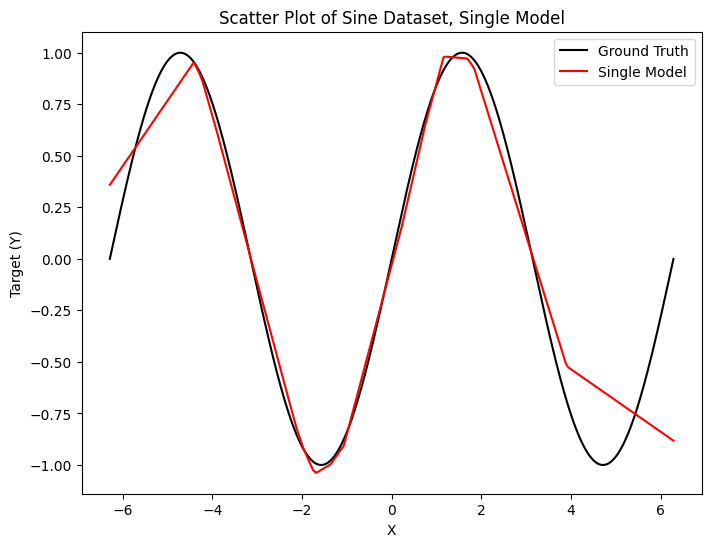

In [ ]:
def get_model_output(params, dataset):
    model = BiggerNN(n, input_dim, output_dim, hidden_dim)
    # Check if the number of parameters in the list matches the number of model parameters
    if len(standard_params) != len(list(model.parameters())):
        print("The number of parameters in the list does not match the number of model parameters.")
    else:
        # Iterate through the model parameters and assign values from the list
        for model_param, param_value in zip(model.parameters(), params):
            model_param.data = param_value

    model_outputs = []
    for xs in dataset.xs:
        model_outputs.append(model(xs).detach())
    return model_outputs



model_outputs = get_model_output(standard_params, dataset)
    

# Extract the data
xs = dataset.xs
ys = dataset.ys

# Plot the data without a colorbar
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, model_outputs, c="red", label="Single Model")

plt.title('Scatter Plot of Sine Dataset, Single Model')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


### Training Deep Ensembles (num_ensemble = 2, 4, 8, 16)

In [ ]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_ensembles = 2
two_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 4
four_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles
)

num_ensembles = 8
eight_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles,
    cache_size=8,
)

num_ensembles = 16
sixteen_particle_params = push.bayes.ensemble.train_deep_ensemble(
    dataloader,
    torch.nn.MSELoss(),
    epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices=1,
    num_ensembles=num_ensembles,
    cache_size=16
)

  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.4835)


  1%|          | 1/100 [00:00<01:38,  1.01it/s]

Average loss 0 tensor(0.4602)


  2%|▏         | 2/100 [00:01<01:15,  1.29it/s]

Average loss 0 tensor(0.4400)


  3%|▎         | 3/100 [00:02<01:08,  1.42it/s]

Average loss 0 tensor(0.4208)


  4%|▍         | 4/100 [00:02<01:04,  1.50it/s]

Average loss 0 tensor(0.4016)


  5%|▌         | 5/100 [00:03<01:01,  1.53it/s]

Average loss 0 tensor(0.3858)


  6%|▌         | 6/100 [00:04<01:00,  1.56it/s]

Average loss 0 tensor(0.3739)


  7%|▋         | 7/100 [00:04<00:59,  1.57it/s]

Average loss 0 tensor(0.3649)


  8%|▊         | 8/100 [00:05<00:58,  1.58it/s]

Average loss 0 tensor(0.3560)


  9%|▉         | 9/100 [00:05<00:57,  1.59it/s]

Average loss 0 tensor(0.3472)


 10%|█         | 10/100 [00:06<00:56,  1.60it/s]

Average loss 0 tensor(0.3383)


 11%|█         | 11/100 [00:07<00:55,  1.60it/s]

Average loss 0 tensor(0.3285)


 12%|█▏        | 12/100 [00:07<00:54,  1.60it/s]

Average loss 0 tensor(0.3180)


 13%|█▎        | 13/100 [00:08<00:54,  1.61it/s]

Average loss 0 tensor(0.3068)


 14%|█▍        | 14/100 [00:09<00:53,  1.61it/s]

Average loss 0 tensor(0.2941)


 15%|█▌        | 15/100 [00:09<00:52,  1.61it/s]

Average loss 0 tensor(0.2806)


 16%|█▌        | 16/100 [00:10<00:51,  1.62it/s]

Average loss 0 tensor(0.2655)


 17%|█▋        | 17/100 [00:10<00:51,  1.62it/s]

Average loss 0 tensor(0.2498)


 18%|█▊        | 18/100 [00:11<00:50,  1.62it/s]

Average loss 0 tensor(0.2328)


 19%|█▉        | 19/100 [00:12<00:49,  1.62it/s]

Average loss 0 tensor(0.2164)


 20%|██        | 20/100 [00:12<00:49,  1.62it/s]

Average loss 0 tensor(0.1973)


 21%|██        | 21/100 [00:13<00:48,  1.62it/s]

Average loss 0 tensor(0.1788)


 22%|██▏       | 22/100 [00:14<00:48,  1.62it/s]

Average loss 0 tensor(0.1607)


 23%|██▎       | 23/100 [00:14<00:47,  1.62it/s]

Average loss 0 tensor(0.1447)


 24%|██▍       | 24/100 [00:15<00:46,  1.62it/s]

Average loss 0 tensor(0.1300)


 25%|██▌       | 25/100 [00:15<00:46,  1.62it/s]

Average loss 0 tensor(0.1171)


 26%|██▌       | 26/100 [00:16<00:45,  1.62it/s]

Average loss 0 tensor(0.1071)


 27%|██▋       | 27/100 [00:17<00:45,  1.62it/s]

Average loss 0 tensor(0.0992)


 28%|██▊       | 28/100 [00:17<00:44,  1.62it/s]

Average loss 0 tensor(0.0927)


 29%|██▉       | 29/100 [00:18<00:43,  1.62it/s]

Average loss 0 tensor(0.0878)


 30%|███       | 30/100 [00:18<00:43,  1.61it/s]

Average loss 0 tensor(0.0840)


 31%|███       | 31/100 [00:19<00:42,  1.62it/s]

Average loss 0 tensor(0.0808)


 32%|███▏      | 32/100 [00:20<00:42,  1.62it/s]

Average loss 0 tensor(0.0783)


 33%|███▎      | 33/100 [00:20<00:41,  1.63it/s]

Average loss 0 tensor(0.0761)


 34%|███▍      | 34/100 [00:21<00:40,  1.62it/s]

Average loss 0 tensor(0.0752)


 35%|███▌      | 35/100 [00:22<00:40,  1.62it/s]

Average loss 0 tensor(0.0734)


 36%|███▌      | 36/100 [00:22<00:39,  1.62it/s]

Average loss 0 tensor(0.0722)


 37%|███▋      | 37/100 [00:23<00:38,  1.63it/s]

Average loss 0 tensor(0.0713)


 38%|███▊      | 38/100 [00:23<00:38,  1.62it/s]

Average loss 0 tensor(0.0709)


 39%|███▉      | 39/100 [00:24<00:37,  1.62it/s]

Average loss 0 tensor(0.0699)


 40%|████      | 40/100 [00:25<00:36,  1.63it/s]

Average loss 0 tensor(0.0696)


 41%|████      | 41/100 [00:25<00:36,  1.62it/s]

Average loss 0 tensor(0.0686)


 42%|████▏     | 42/100 [00:26<00:35,  1.62it/s]

Average loss 0 tensor(0.0679)


 43%|████▎     | 43/100 [00:26<00:35,  1.62it/s]

Average loss 0 tensor(0.0672)


 44%|████▍     | 44/100 [00:27<00:34,  1.62it/s]

Average loss 0 tensor(0.0667)


 45%|████▌     | 45/100 [00:28<00:33,  1.62it/s]

Average loss 0 tensor(0.0664)


 46%|████▌     | 46/100 [00:28<00:33,  1.63it/s]

Average loss 0 tensor(0.0658)


 47%|████▋     | 47/100 [00:29<00:32,  1.63it/s]

Average loss 0 tensor(0.0657)


 48%|████▊     | 48/100 [00:30<00:31,  1.63it/s]

Average loss 0 tensor(0.0649)


 49%|████▉     | 49/100 [00:30<00:31,  1.63it/s]

Average loss 0 tensor(0.0644)


 50%|█████     | 50/100 [00:31<00:30,  1.62it/s]

Average loss 0 tensor(0.0637)


 51%|█████     | 51/100 [00:31<00:30,  1.62it/s]

Average loss 0 tensor(0.0635)


 52%|█████▏    | 52/100 [00:32<00:29,  1.62it/s]

Average loss 0 tensor(0.0627)


 53%|█████▎    | 53/100 [00:33<00:28,  1.63it/s]

Average loss 0 tensor(0.0618)


 54%|█████▍    | 54/100 [00:33<00:28,  1.63it/s]

Average loss 0 tensor(0.0615)


 55%|█████▌    | 55/100 [00:34<00:27,  1.63it/s]

Average loss 0 tensor(0.0611)


 56%|█████▌    | 56/100 [00:34<00:27,  1.63it/s]

Average loss 0 tensor(0.0609)


 57%|█████▋    | 57/100 [00:35<00:26,  1.63it/s]

Average loss 0 tensor(0.0602)


 58%|█████▊    | 58/100 [00:36<00:25,  1.62it/s]

Average loss 0 tensor(0.0598)


 59%|█████▉    | 59/100 [00:36<00:25,  1.62it/s]

Average loss 0 tensor(0.0596)


 60%|██████    | 60/100 [00:37<00:24,  1.62it/s]

Average loss 0 tensor(0.0596)


 61%|██████    | 61/100 [00:38<00:24,  1.62it/s]

Average loss 0 tensor(0.0581)


 62%|██████▏   | 62/100 [00:38<00:23,  1.63it/s]

Average loss 0 tensor(0.0585)


 63%|██████▎   | 63/100 [00:39<00:22,  1.62it/s]

Average loss 0 tensor(0.0576)


 64%|██████▍   | 64/100 [00:39<00:22,  1.62it/s]

Average loss 0 tensor(0.0569)


 65%|██████▌   | 65/100 [00:40<00:21,  1.62it/s]

Average loss 0 tensor(0.0565)


 66%|██████▌   | 66/100 [00:41<00:20,  1.62it/s]

Average loss 0 tensor(0.0562)


 67%|██████▋   | 67/100 [00:41<00:20,  1.62it/s]

Average loss 0 tensor(0.0563)


 68%|██████▊   | 68/100 [00:42<00:19,  1.62it/s]

Average loss 0 tensor(0.0555)


 69%|██████▉   | 69/100 [00:42<00:19,  1.62it/s]

Average loss 0 tensor(0.0548)


 70%|███████   | 70/100 [00:43<00:18,  1.62it/s]

Average loss 0 tensor(0.0544)


 71%|███████   | 71/100 [00:44<00:17,  1.63it/s]

Average loss 0 tensor(0.0540)


 72%|███████▏  | 72/100 [00:44<00:17,  1.62it/s]

Average loss 0 tensor(0.0538)


 73%|███████▎  | 73/100 [00:45<00:16,  1.62it/s]

Average loss 0 tensor(0.0529)


 74%|███████▍  | 74/100 [00:46<00:16,  1.62it/s]

Average loss 0 tensor(0.0528)


 75%|███████▌  | 75/100 [00:46<00:15,  1.62it/s]

Average loss 0 tensor(0.0522)


 76%|███████▌  | 76/100 [00:47<00:14,  1.62it/s]

Average loss 0 tensor(0.0522)


 77%|███████▋  | 77/100 [00:47<00:14,  1.62it/s]

Average loss 0 tensor(0.0515)


 78%|███████▊  | 78/100 [00:48<00:13,  1.62it/s]

Average loss 0 tensor(0.0509)


 79%|███████▉  | 79/100 [00:49<00:12,  1.62it/s]

Average loss 0 tensor(0.0506)


 80%|████████  | 80/100 [00:49<00:12,  1.63it/s]

Average loss 0 tensor(0.0499)


 81%|████████  | 81/100 [00:50<00:11,  1.63it/s]

Average loss 0 tensor(0.0495)


 82%|████████▏ | 82/100 [00:50<00:11,  1.63it/s]

Average loss 0 tensor(0.0493)


 83%|████████▎ | 83/100 [00:51<00:10,  1.63it/s]

Average loss 0 tensor(0.0489)


 84%|████████▍ | 84/100 [00:52<00:09,  1.62it/s]

Average loss 0 tensor(0.0483)


 85%|████████▌ | 85/100 [00:52<00:09,  1.62it/s]

Average loss 0 tensor(0.0480)


 86%|████████▌ | 86/100 [00:53<00:08,  1.62it/s]

Average loss 0 tensor(0.0476)


 87%|████████▋ | 87/100 [00:54<00:08,  1.62it/s]

Average loss 0 tensor(0.0473)


 88%|████████▊ | 88/100 [00:54<00:07,  1.62it/s]

Average loss 0 tensor(0.0467)


 89%|████████▉ | 89/100 [00:55<00:06,  1.62it/s]

Average loss 0 tensor(0.0463)


 90%|█████████ | 90/100 [00:55<00:06,  1.62it/s]

Average loss 0 tensor(0.0459)


 91%|█████████ | 91/100 [00:56<00:05,  1.62it/s]

Average loss 0 tensor(0.0454)


 92%|█████████▏| 92/100 [00:57<00:04,  1.62it/s]

Average loss 0 tensor(0.0452)


 93%|█████████▎| 93/100 [00:57<00:04,  1.62it/s]

Average loss 0 tensor(0.0450)


 94%|█████████▍| 94/100 [00:58<00:03,  1.61it/s]

Average loss 0 tensor(0.0446)


 95%|█████████▌| 95/100 [00:59<00:03,  1.62it/s]

Average loss 0 tensor(0.0439)


 96%|█████████▌| 96/100 [00:59<00:02,  1.62it/s]

Average loss 0 tensor(0.0434)


 97%|█████████▋| 97/100 [01:00<00:01,  1.62it/s]

Average loss 0 tensor(0.0432)


 98%|█████████▊| 98/100 [01:00<00:01,  1.61it/s]

Average loss 0 tensor(0.0426)


 99%|█████████▉| 99/100 [01:01<00:00,  1.61it/s]

Average loss 0 tensor(0.0422)
Average loss 0 tensor(0.0422)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.5166)


  1%|          | 1/100 [00:01<02:37,  1.59s/it]

Average loss 0 tensor(0.4890)


  2%|▏         | 2/100 [00:02<02:15,  1.38s/it]

Average loss 0 tensor(0.4658)


  3%|▎         | 3/100 [00:04<02:06,  1.30s/it]

Average loss 0 tensor(0.4456)


  4%|▍         | 4/100 [00:05<02:01,  1.26s/it]

Average loss 0 tensor(0.4308)


  5%|▌         | 5/100 [00:06<01:57,  1.24s/it]

Average loss 0 tensor(0.4213)


  6%|▌         | 6/100 [00:07<01:55,  1.23s/it]

Average loss 0 tensor(0.4137)


  7%|▋         | 7/100 [00:08<01:53,  1.22s/it]

Average loss 0 tensor(0.4056)


  8%|▊         | 8/100 [00:10<01:52,  1.22s/it]

Average loss 0 tensor(0.3987)


  9%|▉         | 9/100 [00:11<01:50,  1.22s/it]

Average loss 0 tensor(0.3925)


 10%|█         | 10/100 [00:12<01:49,  1.21s/it]

Average loss 0 tensor(0.3862)


 11%|█         | 11/100 [00:13<01:47,  1.21s/it]

Average loss 0 tensor(0.3791)


 12%|█▏        | 12/100 [00:14<01:46,  1.21s/it]

Average loss 0 tensor(0.3715)


 13%|█▎        | 13/100 [00:16<01:45,  1.21s/it]

Average loss 0 tensor(0.3633)


 14%|█▍        | 14/100 [00:17<01:44,  1.21s/it]

Average loss 0 tensor(0.3547)


 15%|█▌        | 15/100 [00:18<01:42,  1.21s/it]

Average loss 0 tensor(0.3448)


 16%|█▌        | 16/100 [00:19<01:41,  1.21s/it]

Average loss 0 tensor(0.3330)


 17%|█▋        | 17/100 [00:20<01:40,  1.21s/it]

Average loss 0 tensor(0.3200)


 18%|█▊        | 18/100 [00:22<01:39,  1.21s/it]

Average loss 0 tensor(0.3059)


 19%|█▉        | 19/100 [00:23<01:38,  1.21s/it]

Average loss 0 tensor(0.2896)


 20%|██        | 20/100 [00:24<01:36,  1.21s/it]

Average loss 0 tensor(0.2717)


 21%|██        | 21/100 [00:25<01:35,  1.21s/it]

Average loss 0 tensor(0.2517)


 22%|██▏       | 22/100 [00:26<01:34,  1.21s/it]

Average loss 0 tensor(0.2308)


 23%|██▎       | 23/100 [00:28<01:33,  1.21s/it]

Average loss 0 tensor(0.2077)


 24%|██▍       | 24/100 [00:29<01:31,  1.21s/it]

Average loss 0 tensor(0.1843)


 25%|██▌       | 25/100 [00:30<01:30,  1.21s/it]

Average loss 0 tensor(0.1626)


 26%|██▌       | 26/100 [00:31<01:29,  1.21s/it]

Average loss 0 tensor(0.1412)


 27%|██▋       | 27/100 [00:33<01:28,  1.21s/it]

Average loss 0 tensor(0.1226)


 28%|██▊       | 28/100 [00:34<01:27,  1.21s/it]

Average loss 0 tensor(0.1070)


 29%|██▉       | 29/100 [00:35<01:25,  1.21s/it]

Average loss 0 tensor(0.0946)


 30%|███       | 30/100 [00:36<01:24,  1.21s/it]

Average loss 0 tensor(0.0848)


 31%|███       | 31/100 [00:37<01:23,  1.21s/it]

Average loss 0 tensor(0.0767)


 32%|███▏      | 32/100 [00:39<01:22,  1.21s/it]

Average loss 0 tensor(0.0717)


 33%|███▎      | 33/100 [00:40<01:21,  1.21s/it]

Average loss 0 tensor(0.0682)


 34%|███▍      | 34/100 [00:41<01:20,  1.22s/it]

Average loss 0 tensor(0.0659)


 35%|███▌      | 35/100 [00:42<01:18,  1.21s/it]

Average loss 0 tensor(0.0639)


 36%|███▌      | 36/100 [00:43<01:17,  1.21s/it]

Average loss 0 tensor(0.0629)


 37%|███▋      | 37/100 [00:45<01:17,  1.23s/it]

Average loss 0 tensor(0.0616)


 38%|███▊      | 38/100 [00:46<01:15,  1.22s/it]

Average loss 0 tensor(0.0608)


 39%|███▉      | 39/100 [00:47<01:14,  1.22s/it]

Average loss 0 tensor(0.0600)


 40%|████      | 40/100 [00:48<01:13,  1.22s/it]

Average loss 0 tensor(0.0595)


 41%|████      | 41/100 [00:50<01:11,  1.22s/it]

Average loss 0 tensor(0.0590)


 42%|████▏     | 42/100 [00:51<01:10,  1.21s/it]

Average loss 0 tensor(0.0587)


 43%|████▎     | 43/100 [00:52<01:09,  1.21s/it]

Average loss 0 tensor(0.0583)


 44%|████▍     | 44/100 [00:53<01:07,  1.21s/it]

Average loss 0 tensor(0.0580)


 45%|████▌     | 45/100 [00:54<01:06,  1.21s/it]

Average loss 0 tensor(0.0576)


 46%|████▌     | 46/100 [00:56<01:05,  1.21s/it]

Average loss 0 tensor(0.0573)


 47%|████▋     | 47/100 [00:57<01:04,  1.21s/it]

Average loss 0 tensor(0.0572)


 48%|████▊     | 48/100 [00:58<01:02,  1.21s/it]

Average loss 0 tensor(0.0567)


 49%|████▉     | 49/100 [00:59<01:01,  1.21s/it]

Average loss 0 tensor(0.0565)


 50%|█████     | 50/100 [01:00<01:00,  1.21s/it]

Average loss 0 tensor(0.0561)


 51%|█████     | 51/100 [01:02<00:58,  1.20s/it]

Average loss 0 tensor(0.0561)


 52%|█████▏    | 52/100 [01:03<00:57,  1.20s/it]

Average loss 0 tensor(0.0556)


 53%|█████▎    | 53/100 [01:04<00:56,  1.20s/it]

Average loss 0 tensor(0.0554)


 54%|█████▍    | 54/100 [01:05<00:55,  1.21s/it]

Average loss 0 tensor(0.0551)


 55%|█████▌    | 55/100 [01:06<00:54,  1.21s/it]

Average loss 0 tensor(0.0550)


 56%|█████▌    | 56/100 [01:08<00:53,  1.20s/it]

Average loss 0 tensor(0.0552)


 57%|█████▋    | 57/100 [01:09<00:51,  1.21s/it]

Average loss 0 tensor(0.0542)


 58%|█████▊    | 58/100 [01:10<00:50,  1.21s/it]

Average loss 0 tensor(0.0539)


 59%|█████▉    | 59/100 [01:11<00:49,  1.21s/it]

Average loss 0 tensor(0.0540)


 60%|██████    | 60/100 [01:12<00:48,  1.21s/it]

Average loss 0 tensor(0.0534)


 61%|██████    | 61/100 [01:14<00:47,  1.21s/it]

Average loss 0 tensor(0.0535)


 62%|██████▏   | 62/100 [01:15<00:45,  1.21s/it]

Average loss 0 tensor(0.0535)


 63%|██████▎   | 63/100 [01:16<00:44,  1.21s/it]

Average loss 0 tensor(0.0530)


 64%|██████▍   | 64/100 [01:17<00:43,  1.21s/it]

Average loss 0 tensor(0.0525)


 65%|██████▌   | 65/100 [01:19<00:42,  1.21s/it]

Average loss 0 tensor(0.0525)


 66%|██████▌   | 66/100 [01:20<00:41,  1.21s/it]

Average loss 0 tensor(0.0525)


 67%|██████▋   | 67/100 [01:21<00:40,  1.21s/it]

Average loss 0 tensor(0.0521)


 68%|██████▊   | 68/100 [01:22<00:38,  1.21s/it]

Average loss 0 tensor(0.0520)


 69%|██████▉   | 69/100 [01:23<00:37,  1.21s/it]

Average loss 0 tensor(0.0518)


 70%|███████   | 70/100 [01:25<00:36,  1.21s/it]

Average loss 0 tensor(0.0514)


 71%|███████   | 71/100 [01:26<00:35,  1.21s/it]

Average loss 0 tensor(0.0510)


 72%|███████▏  | 72/100 [01:27<00:33,  1.21s/it]

Average loss 0 tensor(0.0509)


 73%|███████▎  | 73/100 [01:28<00:32,  1.21s/it]

Average loss 0 tensor(0.0511)


 74%|███████▍  | 74/100 [01:29<00:31,  1.21s/it]

Average loss 0 tensor(0.0505)


 75%|███████▌  | 75/100 [01:31<00:30,  1.21s/it]

Average loss 0 tensor(0.0503)


 76%|███████▌  | 76/100 [01:32<00:29,  1.21s/it]

Average loss 0 tensor(0.0498)


 77%|███████▋  | 77/100 [01:33<00:27,  1.21s/it]

Average loss 0 tensor(0.0501)


 78%|███████▊  | 78/100 [01:34<00:26,  1.20s/it]

Average loss 0 tensor(0.0497)


 79%|███████▉  | 79/100 [01:35<00:25,  1.21s/it]

Average loss 0 tensor(0.0496)


 80%|████████  | 80/100 [01:37<00:24,  1.21s/it]

Average loss 0 tensor(0.0490)


 81%|████████  | 81/100 [01:38<00:23,  1.21s/it]

Average loss 0 tensor(0.0493)


 82%|████████▏ | 82/100 [01:39<00:21,  1.21s/it]

Average loss 0 tensor(0.0490)


 83%|████████▎ | 83/100 [01:40<00:20,  1.21s/it]

Average loss 0 tensor(0.0489)


 84%|████████▍ | 84/100 [01:41<00:19,  1.21s/it]

Average loss 0 tensor(0.0488)


 85%|████████▌ | 85/100 [01:43<00:18,  1.21s/it]

Average loss 0 tensor(0.0484)


 86%|████████▌ | 86/100 [01:44<00:16,  1.21s/it]

Average loss 0 tensor(0.0480)


 87%|████████▋ | 87/100 [01:45<00:15,  1.21s/it]

Average loss 0 tensor(0.0486)


 88%|████████▊ | 88/100 [01:46<00:14,  1.21s/it]

Average loss 0 tensor(0.0477)


 89%|████████▉ | 89/100 [01:48<00:13,  1.21s/it]

Average loss 0 tensor(0.0473)


 90%|█████████ | 90/100 [01:49<00:12,  1.21s/it]

Average loss 0 tensor(0.0474)


 91%|█████████ | 91/100 [01:50<00:10,  1.21s/it]

Average loss 0 tensor(0.0467)


 92%|█████████▏| 92/100 [01:51<00:09,  1.21s/it]

Average loss 0 tensor(0.0469)


 93%|█████████▎| 93/100 [01:52<00:08,  1.21s/it]

Average loss 0 tensor(0.0464)


 94%|█████████▍| 94/100 [01:54<00:07,  1.21s/it]

Average loss 0 tensor(0.0462)


 95%|█████████▌| 95/100 [01:55<00:06,  1.21s/it]

Average loss 0 tensor(0.0460)


 96%|█████████▌| 96/100 [01:56<00:04,  1.21s/it]

Average loss 0 tensor(0.0460)


 97%|█████████▋| 97/100 [01:57<00:03,  1.21s/it]

Average loss 0 tensor(0.0455)


 98%|█████████▊| 98/100 [01:58<00:02,  1.21s/it]

Average loss 0 tensor(0.0453)


 99%|█████████▉| 99/100 [02:00<00:01,  1.21s/it]

Average loss 0 tensor(0.0452)
Average loss 0 tensor(0.0452)


  0%|          | 0/100 [00:00<?, ?it/s]

Average loss 0 tensor(0.4954)


  1%|          | 1/100 [00:02<04:36,  2.79s/it]

Average loss 0 tensor(0.4638)


  2%|▏         | 2/100 [00:05<04:11,  2.57s/it]

Average loss 0 tensor(0.4329)


  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

Average loss 0 tensor(0.4093)


  4%|▍         | 4/100 [00:09<03:55,  2.45s/it]

Average loss 0 tensor(0.3913)


  5%|▌         | 5/100 [00:12<03:50,  2.43s/it]

Average loss 0 tensor(0.3812)


  6%|▌         | 6/100 [00:14<03:46,  2.41s/it]

Average loss 0 tensor(0.3746)


  7%|▋         | 7/100 [00:17<03:43,  2.40s/it]

Average loss 0 tensor(0.3677)


  8%|▊         | 8/100 [00:19<03:40,  2.39s/it]

Average loss 0 tensor(0.3614)


  9%|▉         | 9/100 [00:21<03:37,  2.39s/it]

Average loss 0 tensor(0.3548)


 10%|█         | 10/100 [00:24<03:35,  2.39s/it]

Average loss 0 tensor(0.3487)


 11%|█         | 11/100 [00:26<03:32,  2.39s/it]

Average loss 0 tensor(0.3422)


 12%|█▏        | 12/100 [00:29<03:30,  2.39s/it]

Average loss 0 tensor(0.3355)


 13%|█▎        | 13/100 [00:31<03:27,  2.39s/it]

Average loss 0 tensor(0.3291)


 14%|█▍        | 14/100 [00:33<03:25,  2.39s/it]

Average loss 0 tensor(0.3219)


 15%|█▌        | 15/100 [00:36<03:24,  2.40s/it]

Average loss 0 tensor(0.3149)


 16%|█▌        | 16/100 [00:38<03:21,  2.40s/it]

Average loss 0 tensor(0.3074)


 17%|█▋        | 17/100 [00:41<03:19,  2.40s/it]

Average loss 0 tensor(0.2998)


 18%|█▊        | 18/100 [00:43<03:16,  2.40s/it]

Average loss 0 tensor(0.2916)


 19%|█▉        | 19/100 [00:45<03:14,  2.40s/it]

Average loss 0 tensor(0.2817)


 20%|██        | 20/100 [00:48<03:11,  2.39s/it]

Average loss 0 tensor(0.2708)


 21%|██        | 21/100 [00:50<03:09,  2.39s/it]

Average loss 0 tensor(0.2608)


 22%|██▏       | 22/100 [00:53<03:06,  2.39s/it]

Average loss 0 tensor(0.2486)


 23%|██▎       | 23/100 [00:55<03:03,  2.39s/it]

Average loss 0 tensor(0.2347)


 24%|██▍       | 24/100 [00:57<03:02,  2.40s/it]

Average loss 0 tensor(0.2205)


 25%|██▌       | 25/100 [01:00<03:00,  2.40s/it]

Average loss 0 tensor(0.2068)


 26%|██▌       | 26/100 [01:02<02:57,  2.40s/it]

Average loss 0 tensor(0.1913)


 27%|██▋       | 27/100 [01:05<02:54,  2.40s/it]

Average loss 0 tensor(0.1769)


 28%|██▊       | 28/100 [01:07<02:52,  2.39s/it]

Average loss 0 tensor(0.1624)


 29%|██▉       | 29/100 [01:09<02:49,  2.39s/it]

Average loss 0 tensor(0.1488)


 30%|███       | 30/100 [01:12<02:47,  2.40s/it]

Average loss 0 tensor(0.1373)


 31%|███       | 31/100 [01:14<02:45,  2.40s/it]

Average loss 0 tensor(0.1263)


 32%|███▏      | 32/100 [01:16<02:42,  2.39s/it]

Average loss 0 tensor(0.1174)


 33%|███▎      | 33/100 [01:19<02:40,  2.39s/it]

Average loss 0 tensor(0.1101)


 34%|███▍      | 34/100 [01:21<02:37,  2.39s/it]

Average loss 0 tensor(0.1043)


 35%|███▌      | 35/100 [01:24<02:35,  2.39s/it]

Average loss 0 tensor(0.0996)


 36%|███▌      | 36/100 [01:26<02:33,  2.39s/it]

Average loss 0 tensor(0.0964)


 37%|███▋      | 37/100 [01:28<02:30,  2.39s/it]

Average loss 0 tensor(0.0933)


 38%|███▊      | 38/100 [01:31<02:28,  2.39s/it]

Average loss 0 tensor(0.0926)


 39%|███▉      | 39/100 [01:33<02:25,  2.38s/it]

Average loss 0 tensor(0.0901)


 40%|████      | 40/100 [01:36<02:23,  2.38s/it]

Average loss 0 tensor(0.0891)


 41%|████      | 41/100 [01:38<02:20,  2.39s/it]

Average loss 0 tensor(0.0873)


 42%|████▏     | 42/100 [01:40<02:18,  2.39s/it]

Average loss 0 tensor(0.0864)


 43%|████▎     | 43/100 [01:43<02:16,  2.39s/it]

Average loss 0 tensor(0.0857)


 44%|████▍     | 44/100 [01:45<02:13,  2.39s/it]

Average loss 0 tensor(0.0847)


 45%|████▌     | 45/100 [01:48<02:11,  2.39s/it]

Average loss 0 tensor(0.0832)


 46%|████▌     | 46/100 [01:50<02:09,  2.40s/it]

Average loss 0 tensor(0.0829)


 47%|████▋     | 47/100 [01:52<02:07,  2.40s/it]

Average loss 0 tensor(0.0828)


 48%|████▊     | 48/100 [01:55<02:04,  2.40s/it]

Average loss 0 tensor(0.0817)


 49%|████▉     | 49/100 [01:57<02:02,  2.40s/it]

Average loss 0 tensor(0.0815)


 50%|█████     | 50/100 [02:00<01:59,  2.40s/it]

Average loss 0 tensor(0.0810)


 51%|█████     | 51/100 [02:02<01:57,  2.39s/it]

Average loss 0 tensor(0.0798)


 52%|█████▏    | 52/100 [02:04<01:55,  2.40s/it]

Average loss 0 tensor(0.0790)


 53%|█████▎    | 53/100 [02:07<01:52,  2.40s/it]

Average loss 0 tensor(0.0795)


 54%|█████▍    | 54/100 [02:09<01:50,  2.40s/it]

Average loss 0 tensor(0.0775)


 55%|█████▌    | 55/100 [02:12<01:47,  2.40s/it]

Average loss 0 tensor(0.0788)


 56%|█████▌    | 56/100 [02:14<01:45,  2.40s/it]

Average loss 0 tensor(0.0773)


 57%|█████▋    | 57/100 [02:16<01:43,  2.40s/it]

Average loss 0 tensor(0.0765)


 58%|█████▊    | 58/100 [02:19<01:40,  2.40s/it]

Average loss 0 tensor(0.0763)


 59%|█████▉    | 59/100 [02:21<01:38,  2.40s/it]

Average loss 0 tensor(0.0756)


 60%|██████    | 60/100 [02:24<01:36,  2.40s/it]

Average loss 0 tensor(0.0751)


 61%|██████    | 61/100 [02:26<01:33,  2.40s/it]

Average loss 0 tensor(0.0751)


 62%|██████▏   | 62/100 [02:28<01:31,  2.40s/it]

Average loss 0 tensor(0.0740)


 63%|██████▎   | 63/100 [02:31<01:28,  2.40s/it]

Average loss 0 tensor(0.0735)


 64%|██████▍   | 64/100 [02:33<01:26,  2.40s/it]

Average loss 0 tensor(0.0732)


 65%|██████▌   | 65/100 [02:36<01:23,  2.40s/it]

Average loss 0 tensor(0.0731)


 66%|██████▌   | 66/100 [02:38<01:21,  2.39s/it]

Average loss 0 tensor(0.0719)


 67%|██████▋   | 67/100 [02:40<01:18,  2.39s/it]

Average loss 0 tensor(0.0721)


 68%|██████▊   | 68/100 [02:43<01:16,  2.39s/it]

Average loss 0 tensor(0.0708)


 69%|██████▉   | 69/100 [02:45<01:14,  2.39s/it]

Average loss 0 tensor(0.0708)


 70%|███████   | 70/100 [02:47<01:11,  2.39s/it]

Average loss 0 tensor(0.0701)


 71%|███████   | 71/100 [02:50<01:09,  2.39s/it]

Average loss 0 tensor(0.0704)


 72%|███████▏  | 72/100 [02:52<01:07,  2.39s/it]

Average loss 0 tensor(0.0705)


 73%|███████▎  | 73/100 [02:55<01:04,  2.40s/it]

Average loss 0 tensor(0.0688)


 74%|███████▍  | 74/100 [02:57<01:02,  2.39s/it]

Average loss 0 tensor(0.0690)


 75%|███████▌  | 75/100 [02:59<00:59,  2.40s/it]

Average loss 0 tensor(0.0680)


 76%|███████▌  | 76/100 [03:02<00:57,  2.38s/it]

Average loss 0 tensor(0.0679)


 77%|███████▋  | 77/100 [03:04<00:54,  2.38s/it]

Average loss 0 tensor(0.0672)


 78%|███████▊  | 78/100 [03:07<00:52,  2.39s/it]

Average loss 0 tensor(0.0668)


 79%|███████▉  | 79/100 [03:09<00:50,  2.40s/it]

Average loss 0 tensor(0.0665)


 80%|████████  | 80/100 [03:11<00:47,  2.39s/it]

Average loss 0 tensor(0.0658)


 81%|████████  | 81/100 [03:14<00:45,  2.40s/it]

Average loss 0 tensor(0.0652)


 82%|████████▏ | 82/100 [03:16<00:43,  2.40s/it]

Average loss 0 tensor(0.0648)


 83%|████████▎ | 83/100 [03:19<00:40,  2.40s/it]

Average loss 0 tensor(0.0644)


 84%|████████▍ | 84/100 [03:21<00:38,  2.40s/it]

Average loss 0 tensor(0.0639)


 85%|████████▌ | 85/100 [03:23<00:36,  2.40s/it]

Average loss 0 tensor(0.0635)


 86%|████████▌ | 86/100 [03:26<00:33,  2.40s/it]

Average loss 0 tensor(0.0632)


 87%|████████▋ | 87/100 [03:28<00:31,  2.41s/it]

Average loss 0 tensor(0.0625)


 88%|████████▊ | 88/100 [03:31<00:28,  2.40s/it]

Average loss 0 tensor(0.0625)


 89%|████████▉ | 89/100 [03:33<00:26,  2.40s/it]

Average loss 0 tensor(0.0621)


 90%|█████████ | 90/100 [03:35<00:23,  2.40s/it]

Average loss 0 tensor(0.0615)


 91%|█████████ | 91/100 [03:38<00:21,  2.40s/it]

Average loss 0 tensor(0.0610)


 92%|█████████▏| 92/100 [03:40<00:19,  2.40s/it]

Average loss 0 tensor(0.0607)


 93%|█████████▎| 93/100 [03:43<00:16,  2.39s/it]

Average loss 0 tensor(0.0600)


 94%|█████████▍| 94/100 [03:45<00:14,  2.39s/it]

Average loss 0 tensor(0.0597)


 95%|█████████▌| 95/100 [03:47<00:11,  2.40s/it]

Average loss 0 tensor(0.0592)


 96%|█████████▌| 96/100 [03:50<00:09,  2.40s/it]

Average loss 0 tensor(0.0591)


 97%|█████████▋| 97/100 [03:52<00:07,  2.40s/it]

Average loss 0 tensor(0.0585)


 98%|█████████▊| 98/100 [03:55<00:04,  2.40s/it]

Average loss 0 tensor(0.0577)


 99%|█████████▉| 99/100 [03:57<00:02,  2.40s/it]

Average loss 0 tensor(0.0577)
Average loss 0 tensor(0.0577)


100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


# Get ensemble models
In the cell below we initialize our trained models by creating new instances of the BiggerNN class and assinging the parameters returned from train_deep_ensemble

In [ ]:
def get_ensemble_models(paramList, num_ensembles):
    models = []
    for i in range(num_ensembles):
        model = BiggerNN(n, input_dim, output_dim, hidden_dim)
        
        # Check if the number of parameters in the list matches the number of model parameters
        if len(paramList[i]) != len(list(model.parameters())):
            print("The number of parameters in the list does not match the number of model parameters.")
        else:
            # Iterate through the model parameters and assign values from the list
            for model_param, param_value in zip(model.parameters(), paramList[i]):
                model_param.data = param_value

        models.append(model)
    return models

two_particle_models = get_ensemble_models(two_particle_params, 2)
four_particle_models = get_ensemble_models(four_particle_params, 4)
eight_particle_models = get_ensemble_models(eight_particle_params, 8)
sixteen_particle_models = get_ensemble_models(sixteen_particle_params, 16)

# Get ensemble Output
Then we collect the output for each ensemble by predicting each training datapoint with each of our ensembles individual models. We create a list for each ensemble (two_model_outputs, four_model_outputs, ...), with each item in the list corresponding to a model's predictions over the entire training set.

In [ ]:
def get_ensemble_output(modelList, dataset, num_ensembles):
    outputs = []
    for i in range(num_ensembles):
        model_i_output = []
        for xs in dataset.xs:
            model_i_output.append(modelList[i](xs).detach())
        outputs.append(model_i_output)
    return outputs

def get_ensemble_average(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the average tensors
    averages = []

    # Calculate the average for each list of tensors and add them to the 'averages' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        average_tensor = torch.mean(stacked_tensor, dim=0)
        averages.append(average_tensor)
    return averages

def get_ensemble_variance(outputs):
    transposed_lists = list(map(list, zip(*outputs)))

    # Initialize an empty list to store the variance tensors
    variances = []

    # Calculate the variance for each list of tensors and add them to the 'variances' list
    for tensors in transposed_lists:
        stacked_tensor = torch.stack(tensors)
        variance_tensor = torch.var(stacked_tensor, dim=0)
        variances.append(variance_tensor)
    return variances


# Predictions in sample
two_model_outputs = get_ensemble_output(two_particle_models, dataset, 2)
four_model_outputs = get_ensemble_output(four_particle_models, dataset, 4)
eight_model_outputs = get_ensemble_output(eight_particle_models, dataset, 8)
sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, dataset, 16)


# Average predictions in sample
two_model_averages = get_ensemble_average(two_model_outputs)
four_model_averages = get_ensemble_average(four_model_outputs)
eight_model_averages = get_ensemble_average(eight_model_outputs)
sixteen_model_averages = get_ensemble_average(sixteen_model_outputs)

# Variance of predictions in sample
two_model_var = get_ensemble_variance(two_model_outputs)
four_model_var = get_ensemble_variance(four_model_outputs)
eight_model_var = get_ensemble_variance(eight_model_outputs)
sixteen_model_var = get_ensemble_variance(sixteen_model_outputs)

# Predictions for out of sample
oos_two_model_outputs = get_ensemble_output(two_particle_models, oos_dataset, 2)
oos_four_model_outputs = get_ensemble_output(four_particle_models, oos_dataset, 4)
oos_eight_model_outputs = get_ensemble_output(eight_particle_models, oos_dataset, 8)
oos_sixteen_model_outputs = get_ensemble_output(sixteen_particle_models, oos_dataset, 16)

# Average predictions out of sample
oos_two_model_averages = get_ensemble_average(oos_two_model_outputs)
oos_four_model_averages = get_ensemble_average(oos_four_model_outputs)
oos_eight_model_averages = get_ensemble_average(oos_eight_model_outputs)
oos_sixteen_model_averages = get_ensemble_average(oos_sixteen_model_outputs)

# Variance
oos_two_model_var = get_ensemble_variance(oos_two_model_outputs)
oos_four_model_var = get_ensemble_variance(oos_four_model_outputs)
oos_eight_model_var = get_ensemble_variance(oos_eight_model_outputs)
oos_sixteen_model_var = get_ensemble_variance(oos_sixteen_model_outputs)


Then we stack our output tensors and compute the average

In [ ]:
# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

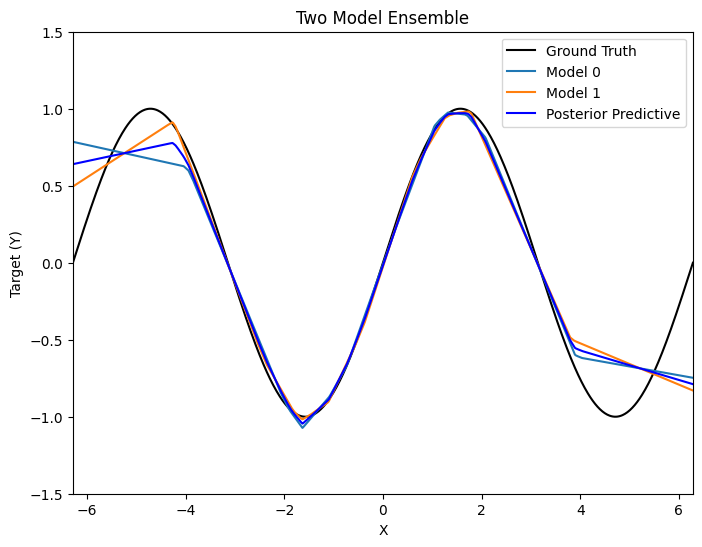

In [ ]:
import numpy as np

# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, two_model_outputs[0], label="Model 0")
plt.plot(xs, two_model_outputs[1], label="Model 1")
plt.plot(xs, two_model_averages, c="blue", label="Posterior Predictive")
plt.title('Two Model Ensemble')
plt.xlim(train_begin_radians, train_end_radians)

plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


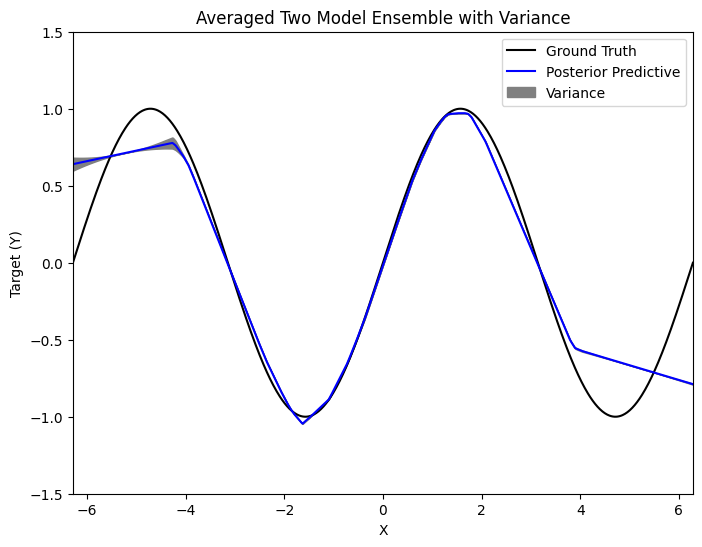

In [ ]:
import numpy as np

# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, two_model_averages, c="blue", label="Posterior Predictive")
plt.title('Averaged Two Model Ensemble with Variance')
plt.xlim(train_begin_radians, train_end_radians)
plt.fill_between(x_flat, (np.array(two_model_averages) - np.array(two_model_var)).flatten(), (np.array(two_model_averages) + np.array(two_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


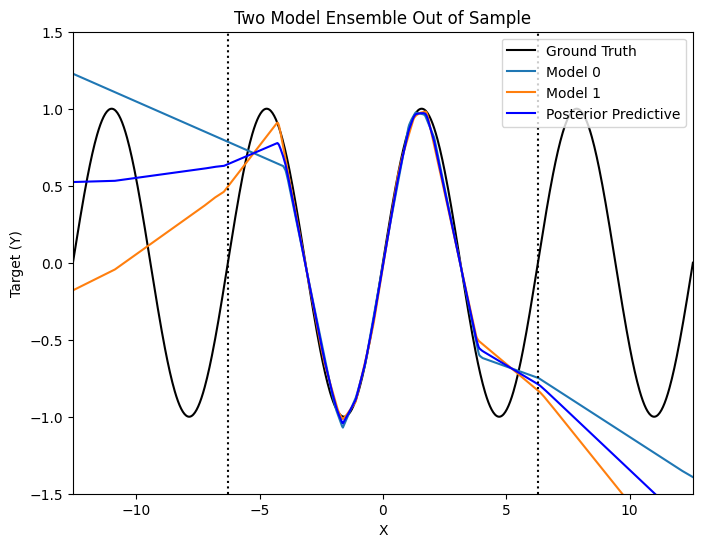

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_two_model_outputs[0], label="Model 0")
plt.plot(oos_xs, oos_two_model_outputs[1], label="Model 1")

plt.plot(oos_xs, oos_two_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)


plt.ylim(-1.5, 1.5)
plt.title('Two Model Ensemble Out of Sample')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


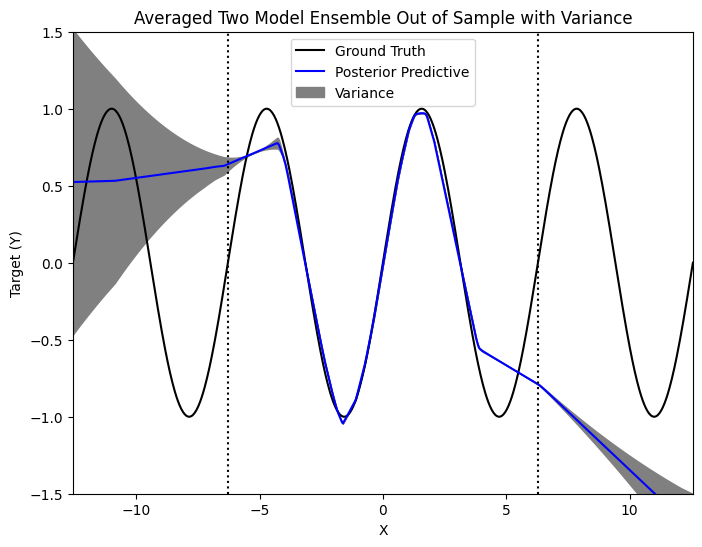

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_two_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.fill_between(oos_x_flat, (np.array(oos_two_model_averages) - np.array(oos_two_model_var)).flatten(), (np.array(oos_two_model_averages) + np.array(oos_two_model_var)).flatten(), color='gray', alpha=1, label="Variance")



plt.ylim(-1.5, 1.5)
plt.title('Averaged Two Model Ensemble Out of Sample with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


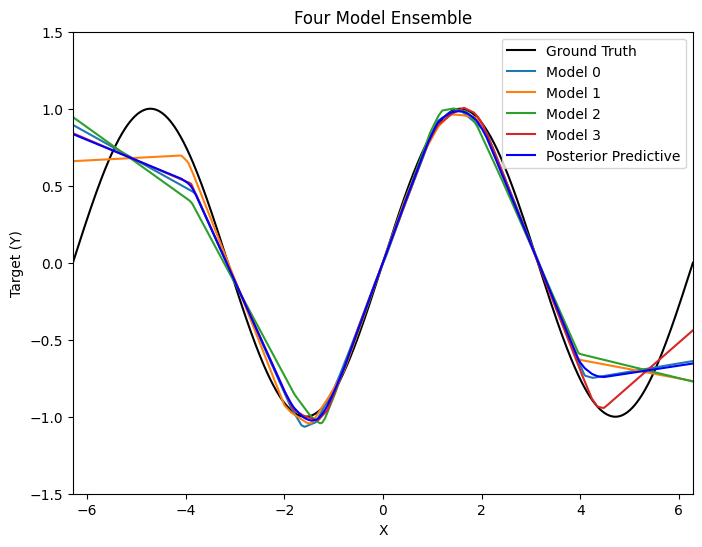

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, four_model_outputs[0], label="Model 0")
plt.plot(xs, four_model_outputs[1], label="Model 1")
plt.plot(xs, four_model_outputs[2], label="Model 2")
plt.plot(xs, four_model_outputs[3], label="Model 3")
plt.plot(xs, four_model_averages, c="blue", label="Posterior Predictive")
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Four Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

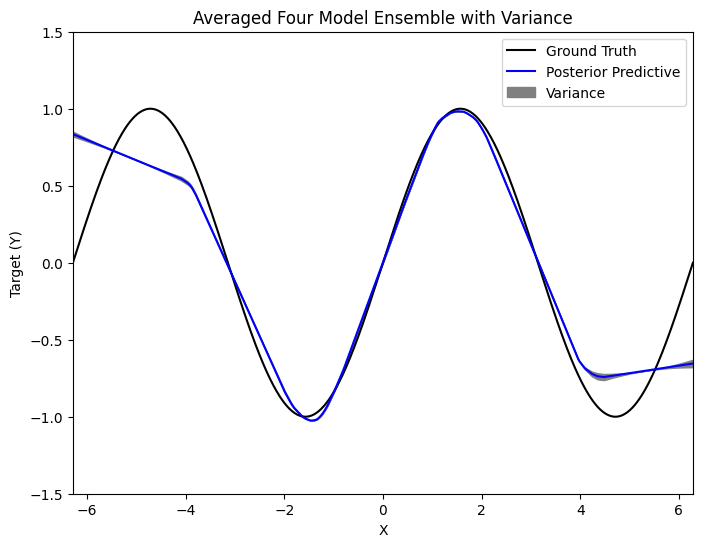

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, four_model_averages, c="blue", label="Posterior Predictive")
plt.fill_between(x_flat, (np.array(four_model_averages) - np.array(four_model_var)).flatten(), (np.array(four_model_averages) + np.array(four_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Averaged Four Model Ensemble with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

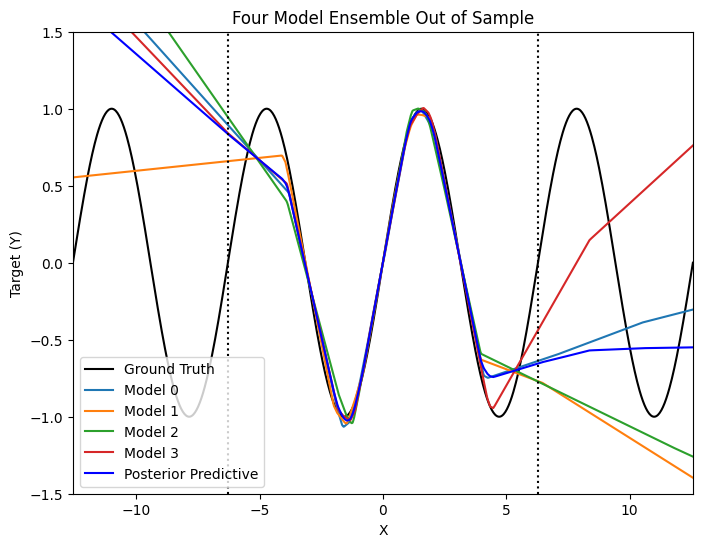

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_four_model_outputs[0], label="Model 0")
plt.plot(oos_xs, oos_four_model_outputs[1], label="Model 1")
plt.plot(oos_xs, oos_four_model_outputs[2], label="Model 2")
plt.plot(oos_xs, oos_four_model_outputs[3], label="Model 3")
plt.plot(oos_xs, oos_four_model_averages, c="blue", label="Posterior Predictive")

plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.title('Four Model Ensemble Out of Sample')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

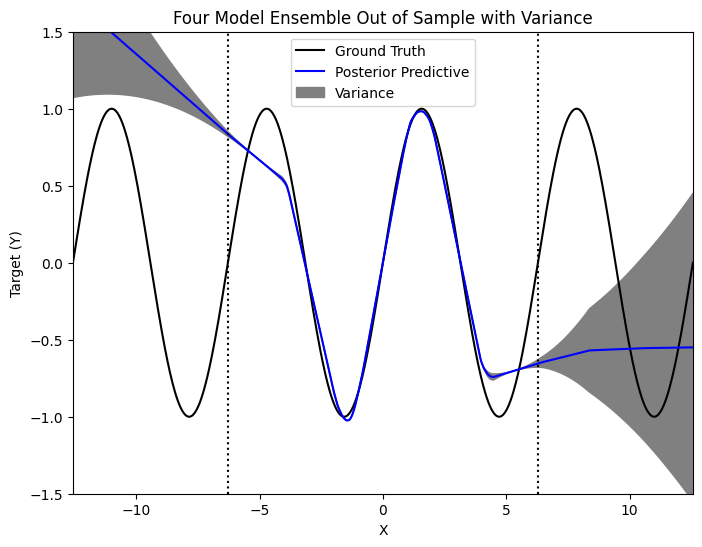

In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, oos_four_model_averages, c="blue", label="Posterior Predictive")
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.fill_between(oos_x_flat, (np.array(oos_four_model_averages) - np.array(oos_four_model_var)).flatten(), (np.array(oos_four_model_averages) + np.array(oos_four_model_var)).flatten(), color='gray', alpha=1, label="Variance")
plt.ylim(-1.5, 1.5)
plt.title('Four Model Ensemble Out of Sample with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


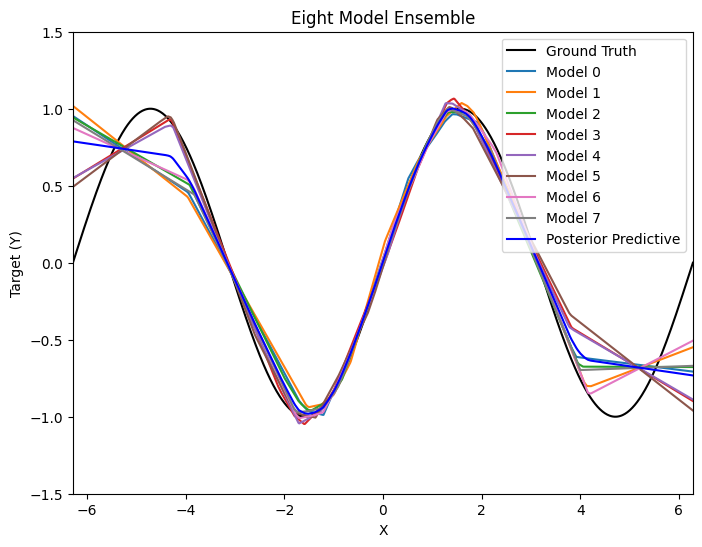

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")
plt.plot(xs, eight_model_outputs[0], label="Model 0")
plt.plot(xs, eight_model_outputs[1], label="Model 1")
plt.plot(xs, eight_model_outputs[2], label="Model 2")
plt.plot(xs, eight_model_outputs[3], label="Model 3")
plt.plot(xs, eight_model_outputs[4], label="Model 4")
plt.plot(xs, eight_model_outputs[5], label="Model 5")
plt.plot(xs, eight_model_outputs[6], label="Model 6")
plt.plot(xs, eight_model_outputs[7], label="Model 7")

plt.plot(xs, eight_model_averages, c="blue", label="Posterior Predictive")
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Eight Model Ensemble')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

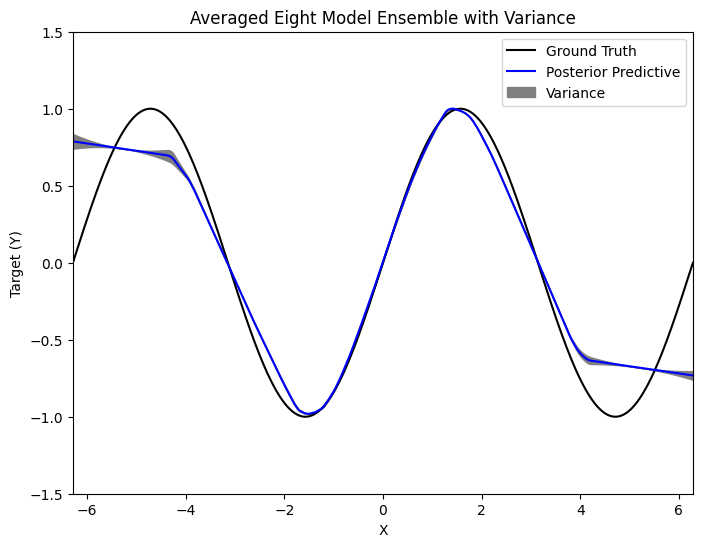

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")

plt.plot(xs, eight_model_averages, c="blue", label="Posterior Predictive")
plt.xlim(train_begin_radians, train_end_radians)
plt.fill_between(x_flat, (np.array(eight_model_averages) - np.array(eight_model_var)).flatten(), (np.array(eight_model_averages) + np.array(eight_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.ylim(-1.5, 1.5)
plt.title('Averaged Eight Model Ensemble with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()

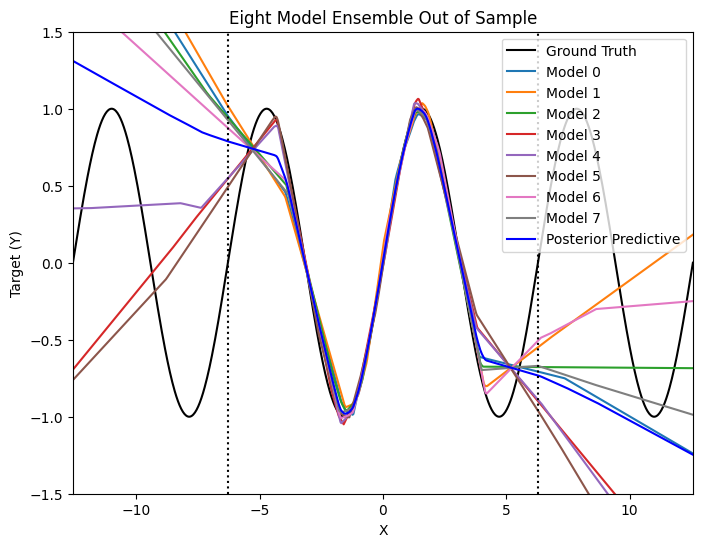

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
for i in range(8):
    plt.plot(oos_xs, oos_eight_model_outputs[i], label=f"Model {i}")
    
plt.plot(oos_xs, oos_eight_model_averages, c="blue", label="Posterior Predictive")

plt.title('Eight Model Ensemble Out of Sample')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

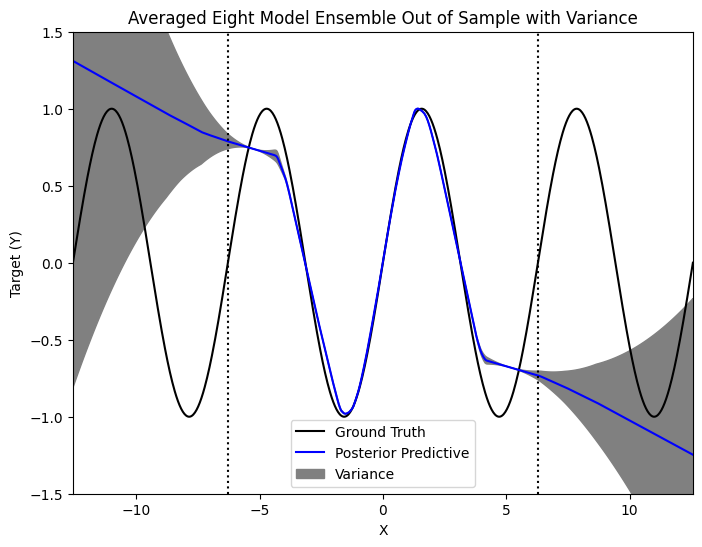

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_eight_model_averages, c="blue", label="Posterior Predictive")
plt.fill_between(oos_x_flat, (np.array(oos_eight_model_averages) - np.array(oos_eight_model_var)).flatten(), (np.array(oos_eight_model_averages) + np.array(oos_eight_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.title('Averaged Eight Model Ensemble Out of Sample with Variance')
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()

In [ ]:
# Plot the data 
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")

# Plot sixteen model outputs
for i in range(16):
    plt.plot(xs, sixteen_model_outputs[i], label=f"Model {i}")

# Calculate and plot the posterior predictive
plt.plot(xs, sixteen_model_averages, c="blue", label="Posterior Predictive")

plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Sixteen Model Ensemble')  # Updated title
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, c="black", label= "Ground Truth")

plt.plot(xs, sixteen_model_averages, c="blue", label="Posterior Predictive")
plt.xlim(train_begin_radians, train_end_radians)
plt.fill_between(x_flat, (np.array(sixteen_model_averages) - np.array(sixteen_model_var)).flatten(), (np.array(sixteen_model_averages) + np.array(sixteen_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.ylim(-1.5, 1.5)
plt.title('Averaged Sixteen Model Ensemble with Variance')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
for i in range(16):
    plt.plot(oos_xs, oos_sixteen_model_outputs[i], label=f"Model {i}")
    
plt.plot(oos_xs, oos_sixteen_model_averages, c="blue", label="Posterior Predictive")

plt.title('Sixteen Model Ensemble Out of Sample')  # Updated title
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


In [ ]:
# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(oos_xs, oos_ys, c="black", label= "Ground Truth")
plt.plot(oos_xs, oos_sixteen_model_averages, c="blue", label="Posterior Predictive")
plt.fill_between(oos_x_flat, (np.array(oos_sixteen_model_averages) - np.array(oos_sixteen_model_var)).flatten(), (np.array(oos_sixteen_model_averages) + np.array(oos_sixteen_model_var)).flatten(), color='gray', alpha=1, label="Variance")

plt.title('Averaged Sixteen Model Ensemble Out of Sample with Variance')  # Updated title
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()


References:

[1] A.G. Wilson, P. Izmailov. Bayesian Deep Learning and a Probabilistic Perspective of Generalization. Advances in Neural Information Processing Systems, 2020.